# <center>SFML/INFO-F422: Statistical foundations of machine learning</center>

# <center>Regression Part</center>

Name: Mathieu Parmentier & Nini

Python version: 3.6

Date: XXXXX


## Introduction

# Objective and strategy 

## Material and method

### Boston home data set: (pour le lire, il ne faut pas faire tourner le data set synthetique)

In [26]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

data = datasets.load_boston()
X = np.array(data.data)
Y = np.array(data.target)
label =data.feature_names

# Pour deux catégorie: 0 ou 1
Y = Y < 22 

Exploration of the data

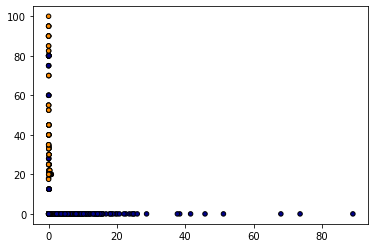

In [27]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])


# Plot all the data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)


plt.show()

### Synthetic data set:

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

# flip_y: put some noise in the function
X, Y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1,n_classes=2, flip_y=.1)
# function of type: z = f(x,y)

Exploration of the synthetic data

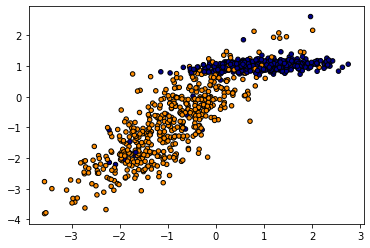

In [2]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])


# Plot all the data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
#plt.xlim(0, 50)
#plt.ylim(0, 40)

plt.show()

Building of the training set and test set

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25)

### 1) Algorithm: Gaussian Naive Bayes

code

In [4]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Score

In [5]:
#Computation of E in and E out
E_in_GNB = GNB.score(x_train, y_train)
E_out_GNB = GNB.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_GNB = cross_val_score(GNB, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_GNB :",cv_scores_GNB)
print("cross validation mean score for GNB :",np.mean(cv_scores_GNB))

cv_scores_GNB : [0.875 0.905 0.87  0.92  0.905]
cross validation mean score for GNB : 0.8949999999999999


Plot of the results

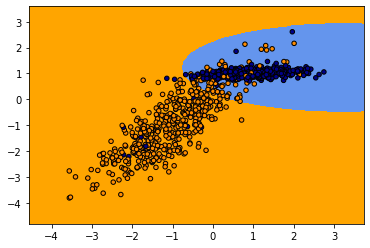

In [6]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = GNB.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

### 2) Algorithm: Support vector classifier/machine → être plus précis sur l'algo utilisé: NuSVC

code

In [7]:
from sklearn import svm

NuSVC = svm.NuSVC(gamma='auto')
NuSVC.fit(x_train, y_train)

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

Score

In [8]:
#Computation of E in and E out
E_in_NuSVC = NuSVC.score(x_train, y_train)
E_out_NuSVC = NuSVC.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_NuSVC = cross_val_score(NuSVC, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_NuSVC :",cv_scores_NuSVC)
print("cross validation mean score for NuSVC :",np.mean(cv_scores_NuSVC))

cv_scores_NuSVC : [0.895 0.92  0.885 0.94  0.905]
cross validation mean score for NuSVC : 0.909


Plot of the results

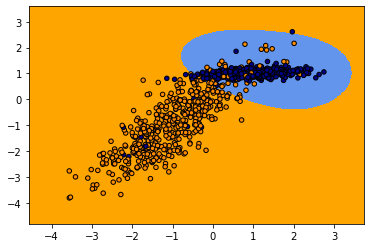

In [10]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = NuSVC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())


plt.show()

### 3) Algorithm: Nearest Neighbors Classification

code

In [12]:
from sklearn import neighbors


n_neighbors = 15
h = .02  # step size in the mesh

NNC_uniform = neighbors.KNeighborsClassifier(n_neighbors, weights= 'uniform')
NNC_distance = neighbors.KNeighborsClassifier(n_neighbors, weights= 'distance')

NNC_uniform.fit(x_train, y_train)
NNC_distance.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

Score

In [14]:
#Computation of E in and E out
E_in_NNC_uniform = NNC_uniform.score(x_train, y_train)
E_out_NNC_uniform = NNC_uniform.score(x_test, y_test)

E_in_NNC_distance = NNC_distance.score(x_train, y_train)
E_out_NNC_distance = NNC_distance.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_NNC_uniform = cross_val_score(NNC_uniform, X, Y, cv=5)
cv_scores_NNC_distance = cross_val_score(NNC_distance, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_NNC_uniform :",cv_scores_NNC_uniform)
print("cross validation mean score for NNC_uniform :",np.mean(cv_scores_NNC_uniform))
print("cv_scores_NNC_distance :",cv_scores_NNC_distance)
print("cross validation mean score for NNC_distance :",np.mean(cv_scores_NNC_distance))

cv_scores_NNC_uniform : [0.895 0.94  0.905 0.95  0.91 ]
cross validation mean score for NNC_uniform : 0.9200000000000002
cv_scores_NNC_distance : [0.89  0.935 0.905 0.96  0.91 ]
cross validation mean score for NNC_distance : 0.9200000000000002


Plot of the results

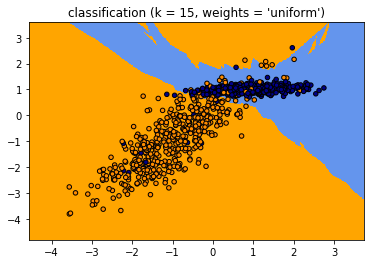

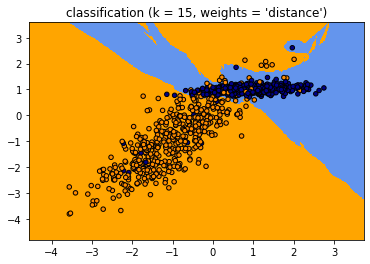

In [15]:
from sklearn import neighbors


n_neighbors = 15


h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(x_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.title("classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

### 4) Algorithm: Random Forest Classifier

code

In [16]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier)

RFC = RandomForestClassifier(max_depth=2, random_state=0)
RFC.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Score

In [17]:
#Computation of E in and E out
E_in_RFC = RFC.score(x_train, y_train)
E_out_RFC = RFC.score(x_test, y_test)

#cross validation of the model with cv = 5
from sklearn.model_selection import cross_val_score
cv_scores_RFC = cross_val_score(RFC, X, Y, cv=5)

#print the cross validation score and average
print("cv_scores_RFC :",cv_scores_RFC)
print("cross validation mean score for RFC :",np.mean(cv_scores_RFC))

cv_scores_RFC : [0.895 0.95  0.905 0.955 0.935]
cross validation mean score for RFC : 0.9280000000000002


Plot of the results

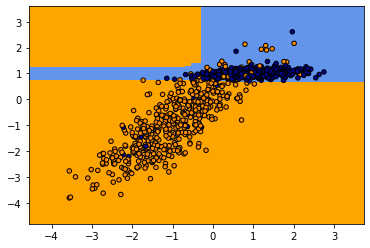

In [18]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = RFC.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,edgecolor='k', s=20)

plt.show()

### Algorithm 1: Random Forest

In [8]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

In [10]:
from sklearn import datasets #import datasets from scikit-learn

In [11]:
data = datasets.load_boston()

In [12]:
# define the data/predictors as the pre-set feature names
X = pd.DataFrame(data.data, columns=data.feature_names)

In [13]:
X.head(6)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21


In [15]:
# Put the target (housin value -- MEDV) in another DataFrame
Y = pd.DataFrame(data.target, columns=["MEDV"])

In [16]:
Y.head(5) #continuous numerical variable

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [17]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25) #20M hol out for testing

#### **Random forest regression**

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [19]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [20]:
regr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [21]:
print(regr.feature_importances_)

[0.         0.         0.         0.         0.00729892 0.70021159
 0.         0.         0.         0.         0.         0.
 0.29248949]


In [22]:
importances = regr.feature_importances_ #RF based predictor variavle importance

In [25]:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" %(f + 1, indices[f], importances[indices[f]]))

1. feature 5 (0.700212)
2. feature 12 (0.292489)
3. feature 4 (0.007299)
4. feature 11 (0.000000)
5. feature 10 (0.000000)
6. feature 9 (0.000000)
7. feature 8 (0.000000)
8. feature 7 (0.000000)
9. feature 6 (0.000000)
10. feature 3 (0.000000)
11. feature 2 (0.000000)
12. feature 1 (0.000000)
13. feature 0 (0.000000)


In [26]:
X.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [27]:
Y_pred = regr.predict(X_test)

In [28]:
Y_pred

array([15.36462224, 15.36462224, 23.01660873, 14.54563994, 16.25055599,
       23.01660873, 24.08692209, 14.54563994, 14.54563994, 41.65039063,
       14.54563994, 14.54563994, 17.13054181, 23.01660873, 25.0774782 ,
       23.01660873, 23.01660873, 14.54563994, 14.54563994, 23.01660873,
       23.01660873, 14.54563994, 23.01660873, 31.98945675, 23.01660873,
       23.01660873, 45.0534172 , 23.01660873, 23.01660873, 23.01660873,
       23.01660873, 24.08692209, 23.01660873, 23.01660873, 14.54563994,
       23.01660873, 23.01660873, 23.01660873, 30.06063136, 23.01660873,
       23.01660873, 23.01660873, 14.54563994, 16.25055599, 14.54563994,
       23.01660873, 14.54563994, 23.01660873, 31.98945675, 14.54563994,
       14.54563994, 15.36462224, 25.9094525 , 23.01660873, 23.01660873,
       14.54563994, 31.98945675, 24.08692209, 14.54563994, 24.08692209,
       14.54563994, 22.1699973 , 23.01660873, 23.01660873, 24.08692209,
       14.54563994, 23.01660873, 24.08692209, 23.01660873, 23.01

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
mean_squared_error(y_test, Y_pred)

33.03367144178237

In [32]:
from sklearn.metrics import r2_score

In [33]:
r2_score(y_test, Y_pred)

0.5156731310597823

In [34]:
#define the data/predictors as the pre-set feature names
X = pd.DataFrame(data.data, columns=data.feature_names)

In [35]:
X.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [36]:
X1=X[["RM","LSTAT"]] #let's work with 2 predictor variables

In [37]:
# Put the target (housing value -- MEDV) in another DataFrame
Y = pd.DataFrame(data.target, columns=["MEDV"])

In [38]:
#split the data
X1_train, X1_test, y_train, y_test = train_test_split(X1, Y, test_size = .2, random_state=25) #20% hold out for testing

In [39]:
regr.fit(X1_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [40]:
Y1_pred = regr.predict(X1_test)

In [41]:
mean_squared_error(y_test, Y1_pred) #MSE

33.28128491726266

In [42]:
print(regr.feature_importances_)

[0.70093174 0.29906826]


## Results & Discusion

!!!!!!!!!!!!!! à faire tableau récapitulatif des résultats !!!!!!!!

## Conclusion 

## Bibliography

 Lecture + ...